<a href="https://colab.research.google.com/github/broadinstitute/BEClust3D/blob/add_qc/BEClust3D_v1_SingleScreen_SingleGene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Steps

In [1]:
# @title Imports
# @markdown Import BEClust3D from Github and other necessary packages
! pip uninstall beclust3d -y
! pip install git+https://github.com/broadinstitute/BEClust3D.git@add_qc
! pip install pandas
! pip install numpy
! pip install matplotlib

  Cloning https://github.com/broadinstitute/BEClust3D.git (to revision add_qc) to /tmp/pip-req-build-u1yvpf06
  Running command git clone --filter=blob:none --quiet https://github.com/broadinstitute/BEClust3D.git /tmp/pip-req-build-u1yvpf06
  Running command git checkout -b add_qc --track origin/add_qc
  Switched to a new branch 'add_qc'
  Branch 'add_qc' set up to track remote branch 'add_qc' from 'origin'.
  Resolved https://github.com/broadinstitute/BEClust3D.git to commit 988b0490ab53e2813a36074a715d0722f92f0fe0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.4 MB/s eta 0:00:00
  Created wheel for beclust3d: filename=beclust3d-2024.0.0-py3-none-any.whl size=8281100 sha256=6e14cf8d5c7703994918db154d3d5e5c6ee85f2290f08b50ec4

In [2]:
# @title Imports
# @markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Import Google Drive
# @markdown Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# @markdown If files are in Google Drive, add 'drive/' in front of path
workdir = 'drive/MyDrive/beclust3d/' # @param {type:"string"}

In [6]:
# @markdown Separate screen file names by comma
screens = 'Human_InVitro_294T_Apobec_D14_Input.txt' # @param {type:"string"}
screens = screens.split(',')

input_gene = 'SETDB1' # @param {type:"string"}
input_uniprot = 'Q15047' # @param {type:"string"}
structureid = f"AF-{input_uniprot}-F1-model_v4"

# Formatting Data for Input (Optional)

In [8]:
# @markdown Check input columns are in an appropriate format

# @markdown If MUT_COL and EDITS_COL are a list of mutations and edits as opposed to one category, this code chunk reformats them into separate rows. Otherwise, an error is thrown.

def count_commas(s):
    if pd.isna(s):
        return 0
    return s.count(',')

mut_list_col = "Mutation_Category" # @param {type:"string"}
mut_col = "Histogram_Category" # @param {type:"string"}
val_col = "Input" # @param {type:"string"}
gene_col = "TargetGeneSymbol" # @param {type:"string"}
edits_col = "AminoAcidEdits" # @param {type:"string"}
gRNA_col = "gRNA_seq" # @param {type:"string"}

# @markdown If your data does not have a single mutation type for each score \
# @markdown Establish a hierarchy for mutation type importance \
# @markdown This will overwrite the MUT_COL column of your dataframe

assign_hierachy = False #@param {type: "boolean"}
hierachy = "Nonsense, Splice Site, Missense, Intron, Silent, UTR, Flank, No Mutation" # @param {type:"string"}
hierachy_list = [x.strip() for x in hierachy.split(',')]
mutation_hierarchy = {mutation: idx for idx, mutation in enumerate(hierachy_list)}

# Function to determine the Mutation_Category based on Mutation_Type
def prioritize_mutations(mutation_types):
    if not mutation_types or pd.isna(mutation_types):
        return "No Mutation"
    mutation_list = mutation_types.split(',')

    # Replace "Splice-donor" and "Splice-acceptor" with "Splice Site"
    mutation_list = ["Splice Site" if "Splice" in mutation else mutation for mutation in mutation_list]
    # Filter out mutation types not in the hierarchy list
    mutation_list = [mutation for mutation in mutation_list if mutation in mutation_hierarchy]

    # If no recognized mutation types are found, return an empty string
    if not mutation_list:
        return ""
    # Sort the mutations based on the defined hierarchy
    mutation_list.sort(key=lambda x: mutation_hierarchy.get(x, float('inf')))

    return mutation_list[0]

# CHECK INPUT #
for i, screen in enumerate(screens):
  df_screen = pd.read_csv(f'{workdir}rawdata/{screen}', sep='\t')
  assert all(x in df_screen.columns for x in [mut_list_col, mut_col, val_col, gene_col, edits_col]), "Input column(s) are not in the dataframe"
  # assert all(x in df_screen.columns for x in [mut_list_col, mut_col, val_col, gene_col, edits_col, gRNA_col]), "Input column(s) are not in the dataframe"

  # CHECK VAL_COL a list of values
  assert all(isinstance(x, float) for x in df_screen[val_col]), "val_col is not an float"

  # CHECK GENE_COL a list of gene names
  unique_genes = df_screen[gene_col].unique()
  unique_genes.sort()
  print(f'All genes present in screen {screen}', unique_genes)
  assert all(isinstance(x, str) for x in df_screen[gene_col]), "gene_col is not a string"

  # # CHECK gRNA_COL
  # assert all(isinstance(x, str) for x in df_screen[gRNA_col]), "gRNA_col is not a string"
  # assert all(len(x)==20 for x in df_screen[gRNA_col]), "gRNA_col should be 20 bps"

  # CHECK MUT_LIST_COL and EDITS_COL MATCH
  mismatch_rows = df_screen[df_screen[mut_list_col].apply(lambda x: count_commas(x)) != df_screen[edits_col].apply(lambda x: count_commas(x))]
  assert mismatch_rows.empty, "MUT_LIST_COL and EDITS_COL do not match"
  if not mismatch_rows.empty:
    print('Check the following rows')
    print(df_screen[mismatch_rows])

  # PRIORITIZE MUT_COL BASED ON MUT_LIST_COL
  if assign_hierachy:
    df_screen[mut_col] = df_screen[mut_list_col].apply(lambda x: prioritize_mutations(x))
    new_screen = screen.split('.')[0]+'_prioritized.'+screen.split('.')[1]
    print(screen, 'renamed to', new_screen)
    df_screen.to_csv(f'rawdata/{new_screen}', sep='\t', index=False)
    screens[i] = new_screen


All genes present in screen Human_InVitro_294T_Apobec_D14_Input.txt ['ATF7IP' 'ATF7IP2' 'EHMT1' 'EHMT2' 'MORC2' 'MPHOSPH8' 'PPHLN1' 'PTPN2'
 'SETDB1' 'SETDB2' 'SUV39H1' 'SUV39H2' 'TASOR' 'TRIM28']


# Preprocess Screens, and Query Structure and Conservation

Count of Nonsense rows: 33
Count of Splice Site rows: 19
Count of Missense rows: 282
Count of No Mutation rows: 168
Count of Silent rows: 109


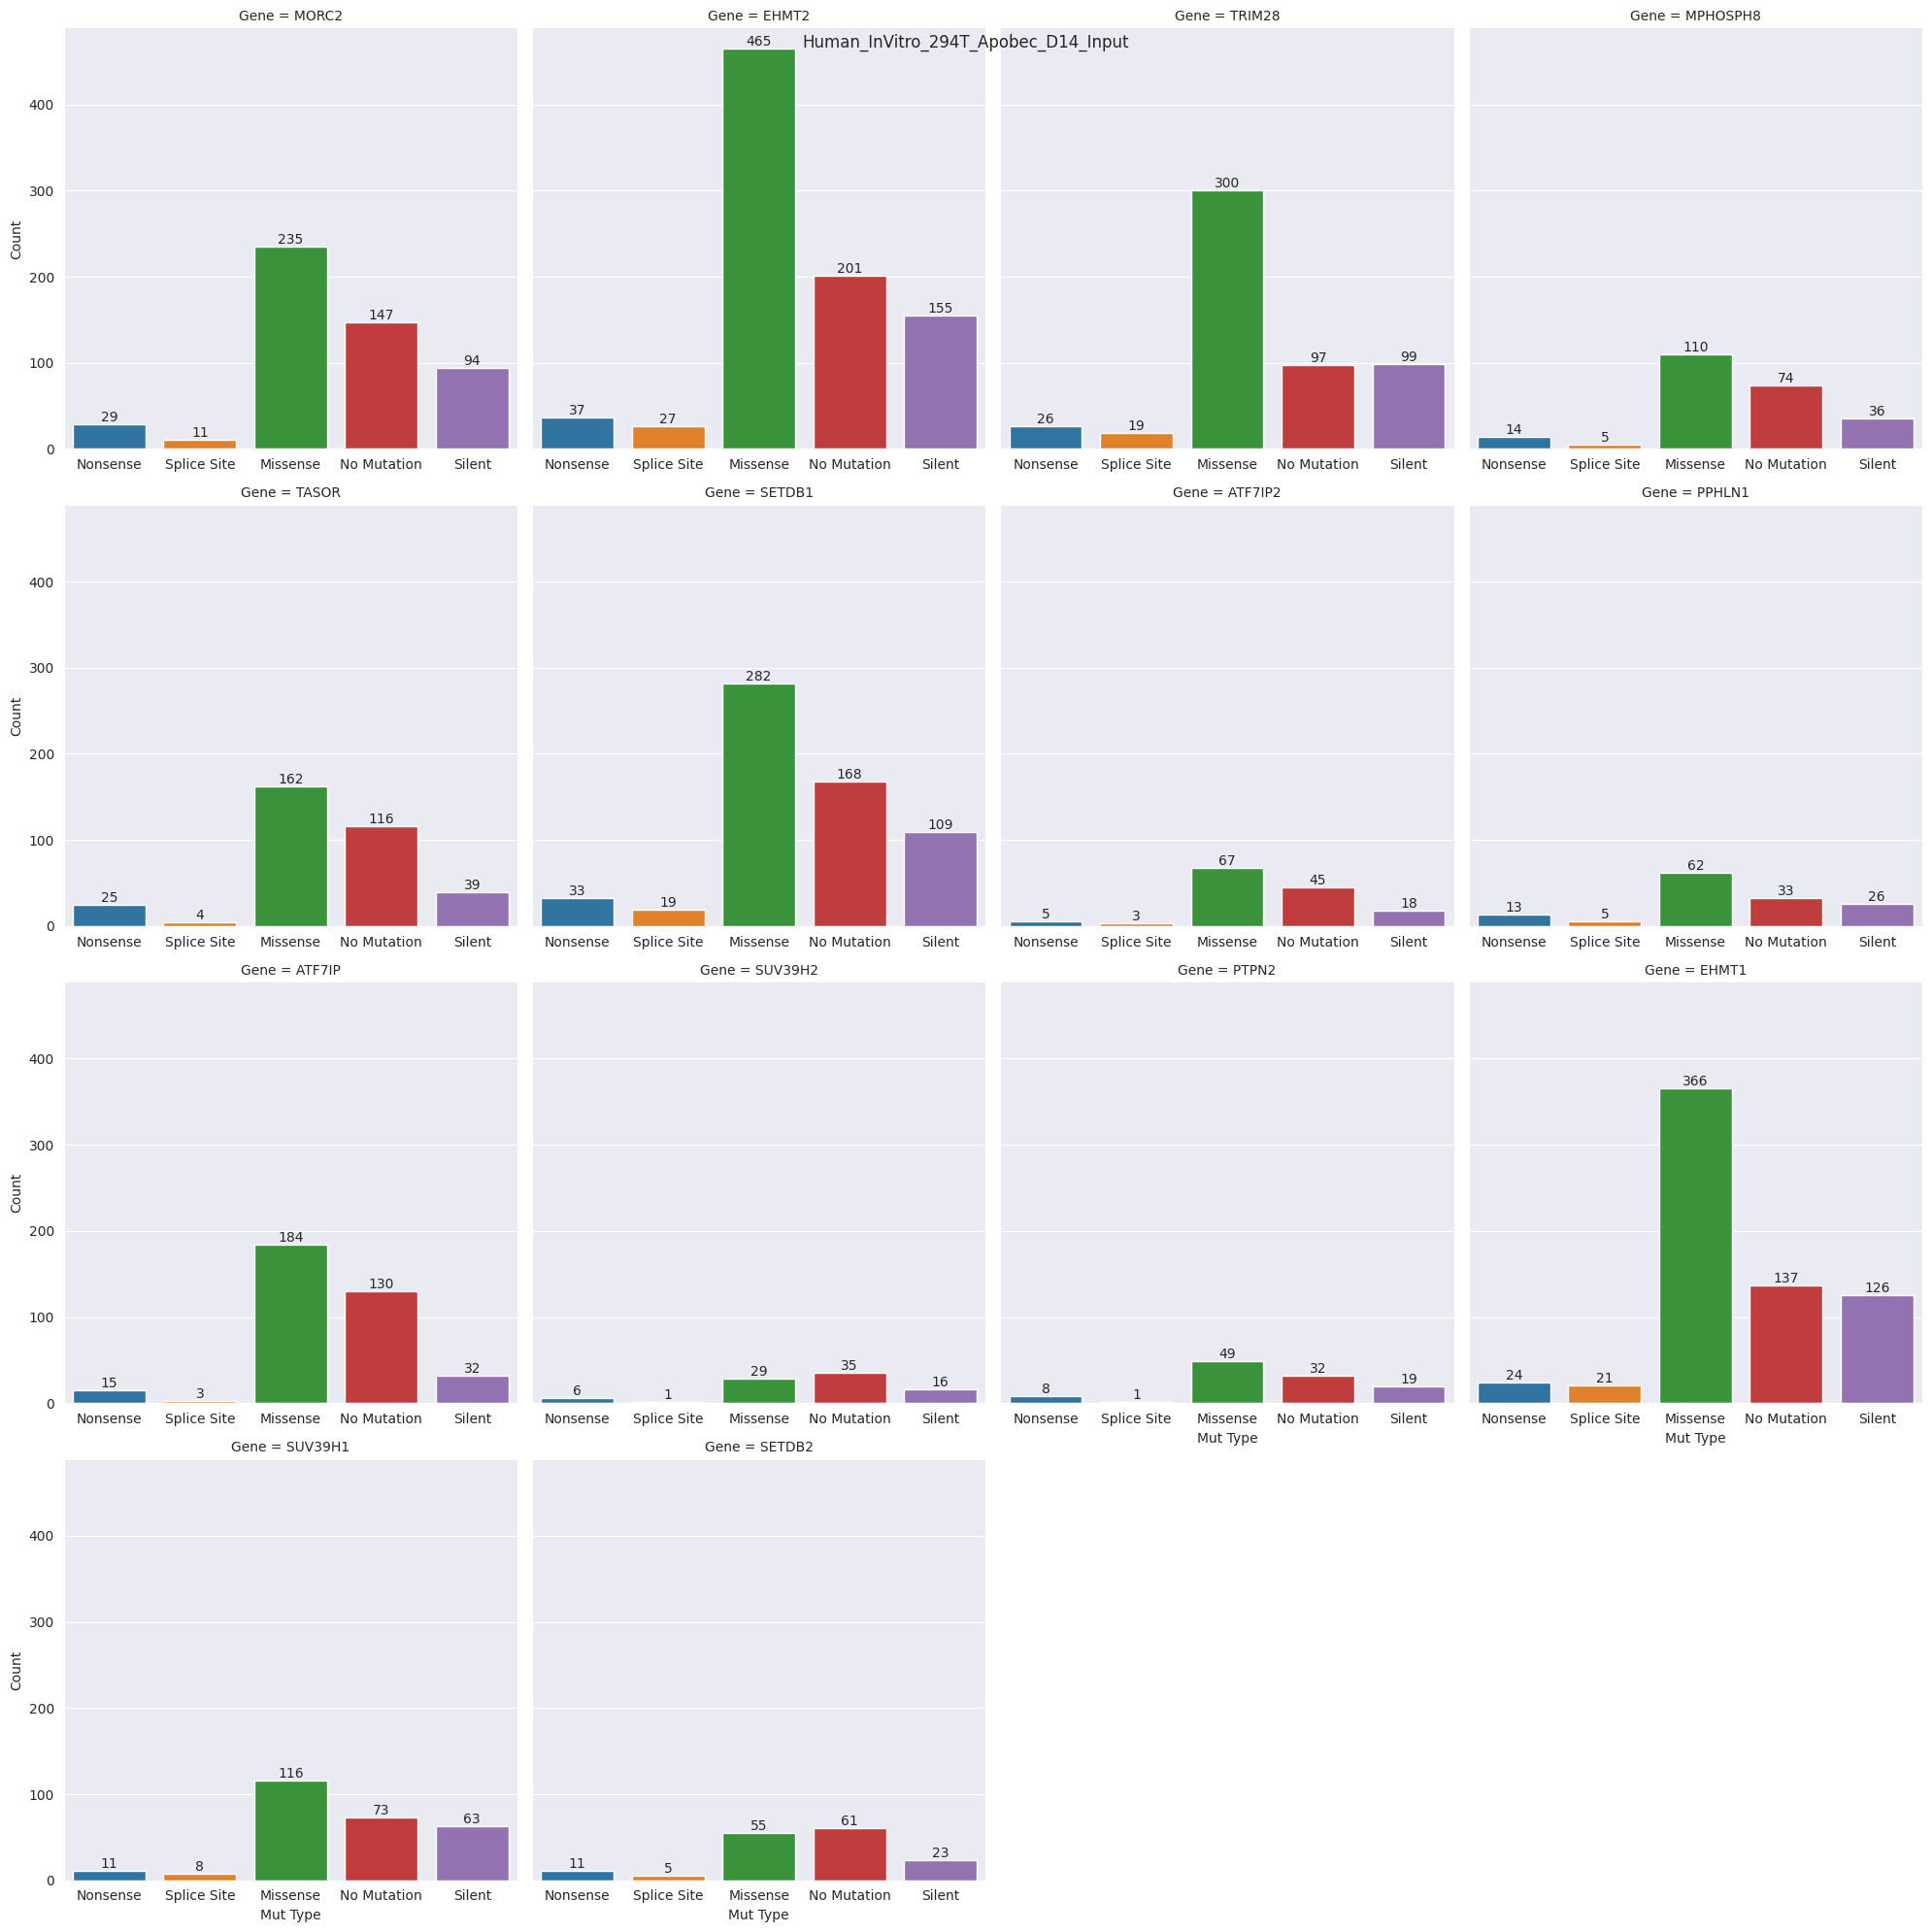

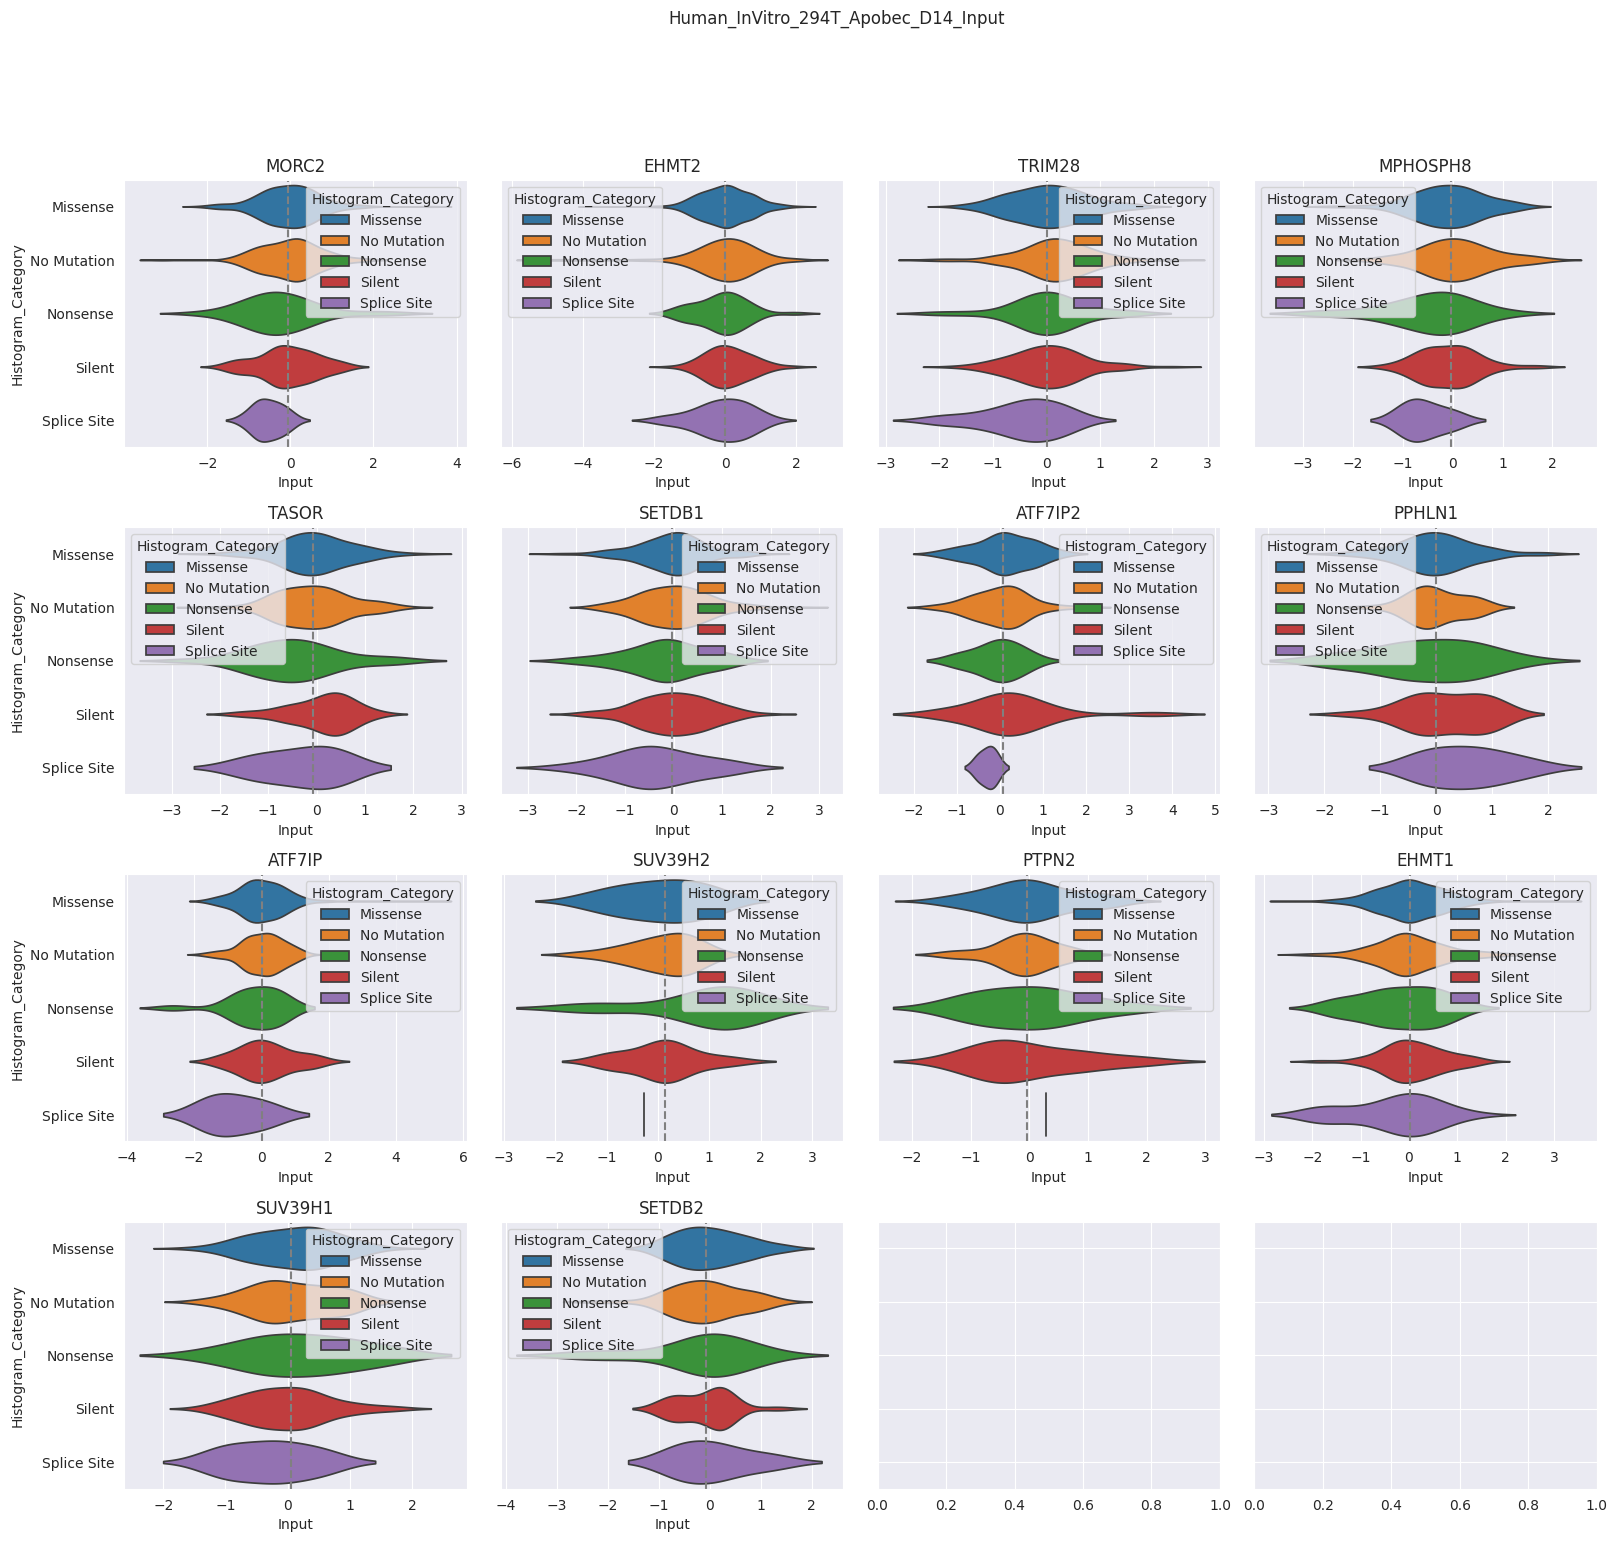

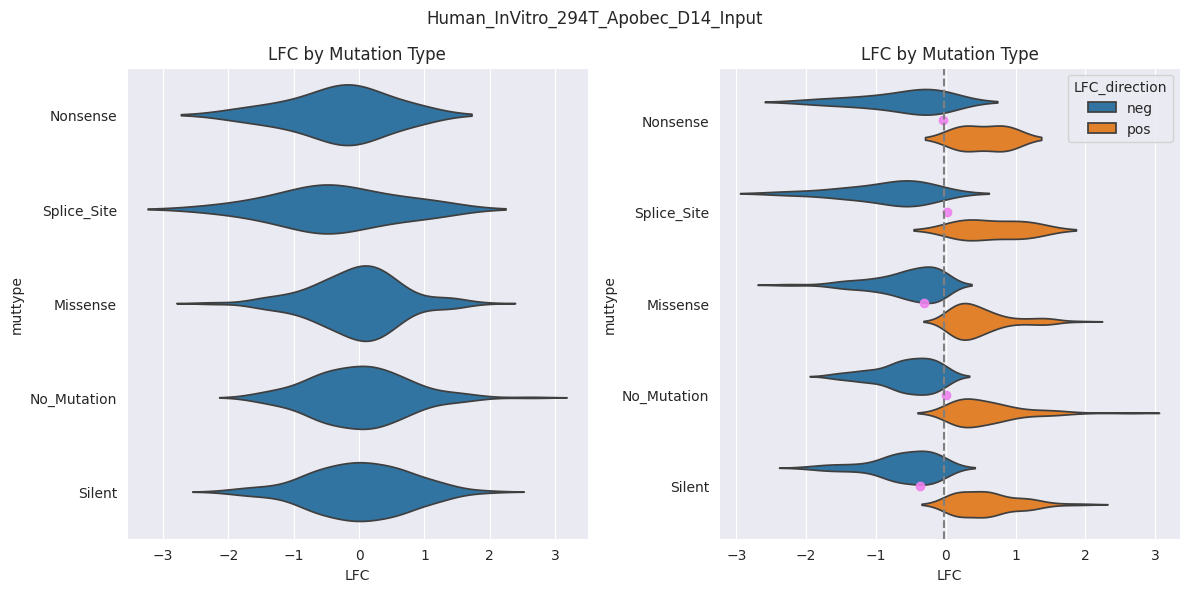

In [9]:
# @markdown Preprocess screen data and QC plots

from beclust3d.preprocess_be_results import parse_base_editing_results

df_inputs = [pd.read_csv(f'{workdir}rawdata/{screen}', sep='\t') for screen in screens]
_ = parse_base_editing_results(
    df_Inputs = df_inputs,
    workdir = workdir, input_gene = input_gene, input_screens = screens,
    mut_col=mut_col, val_col=val_col, gene_col=gene_col, edits_col=edits_col,
    )

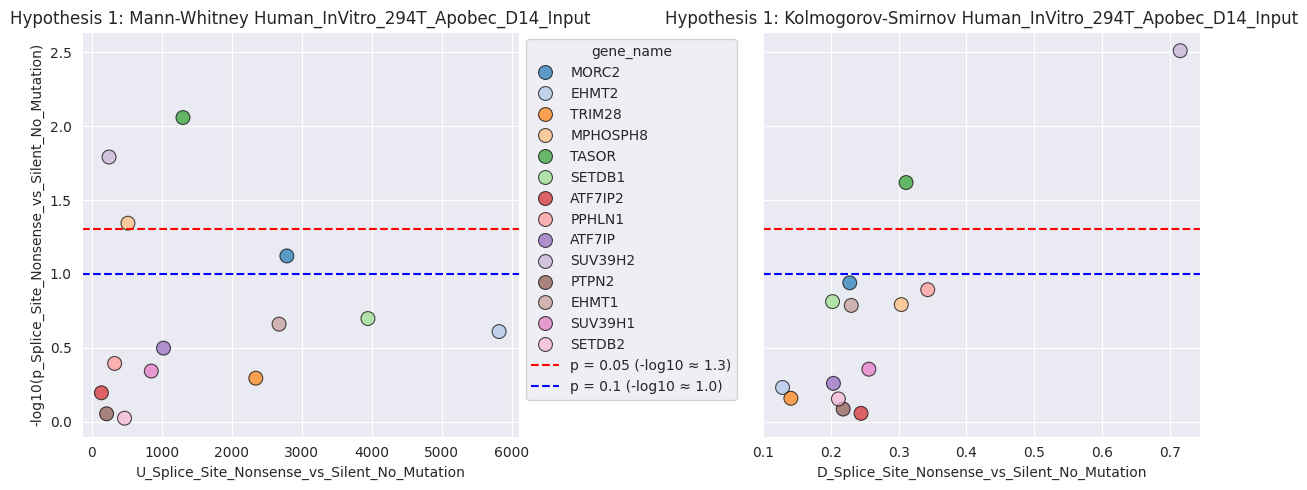

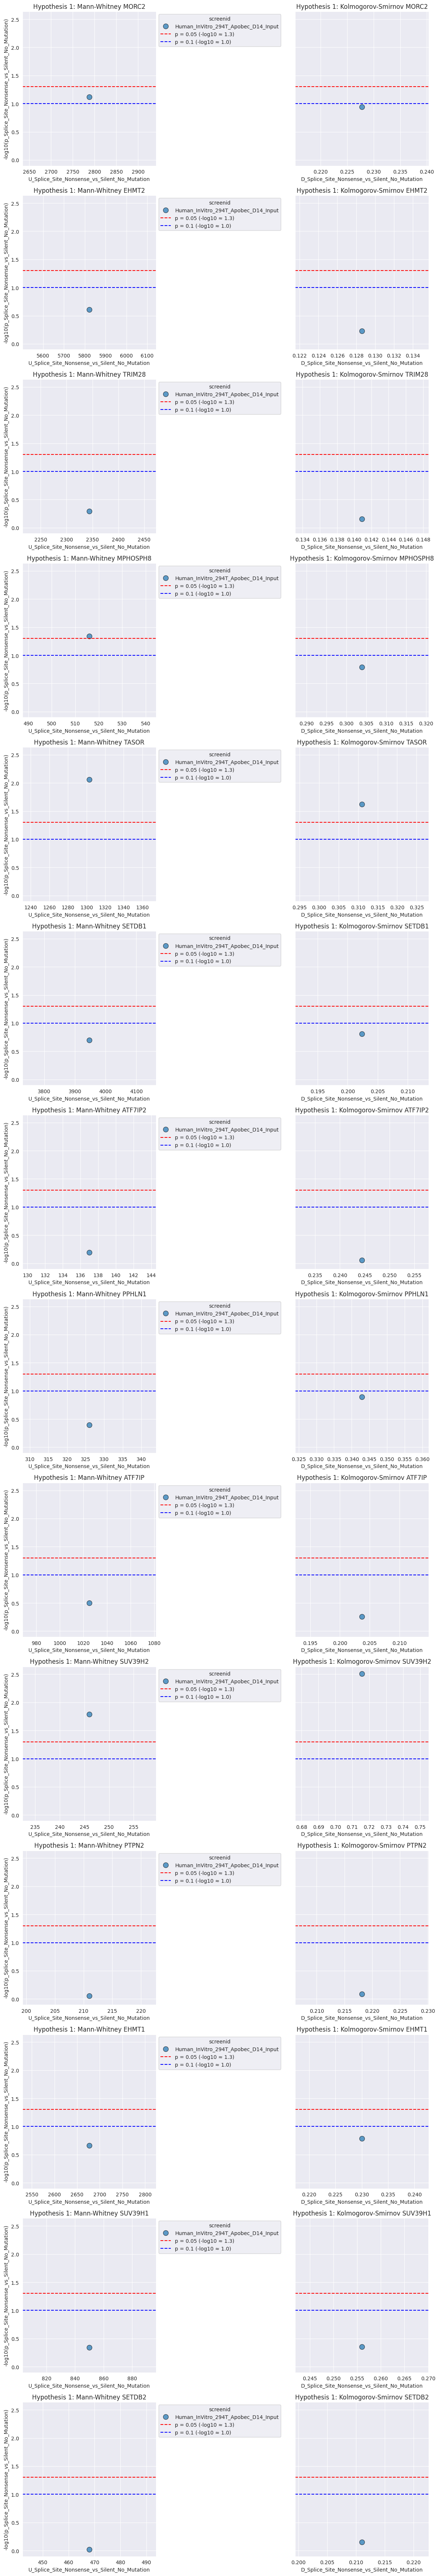

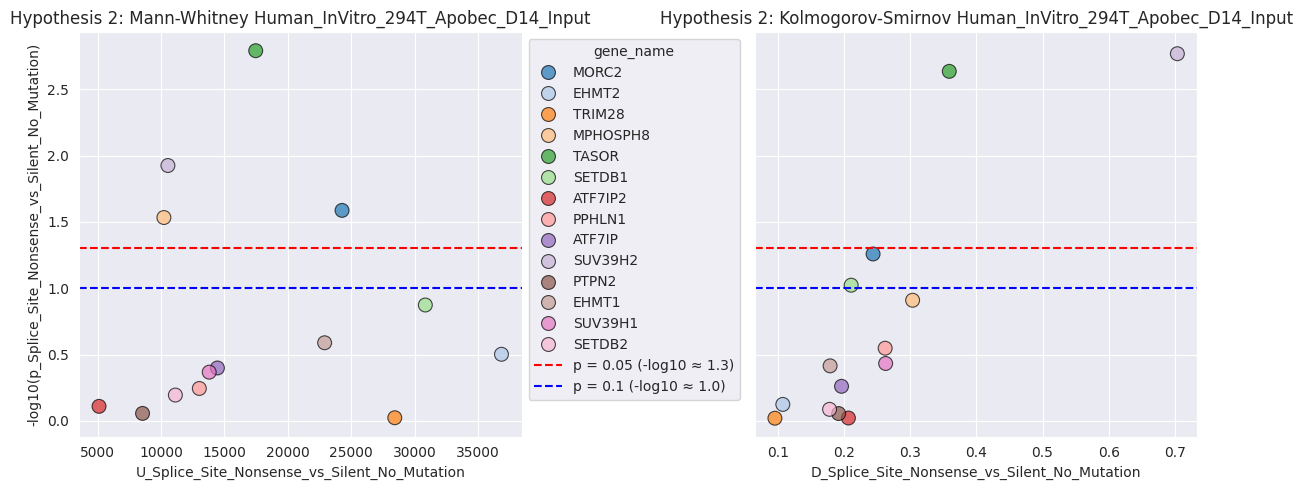

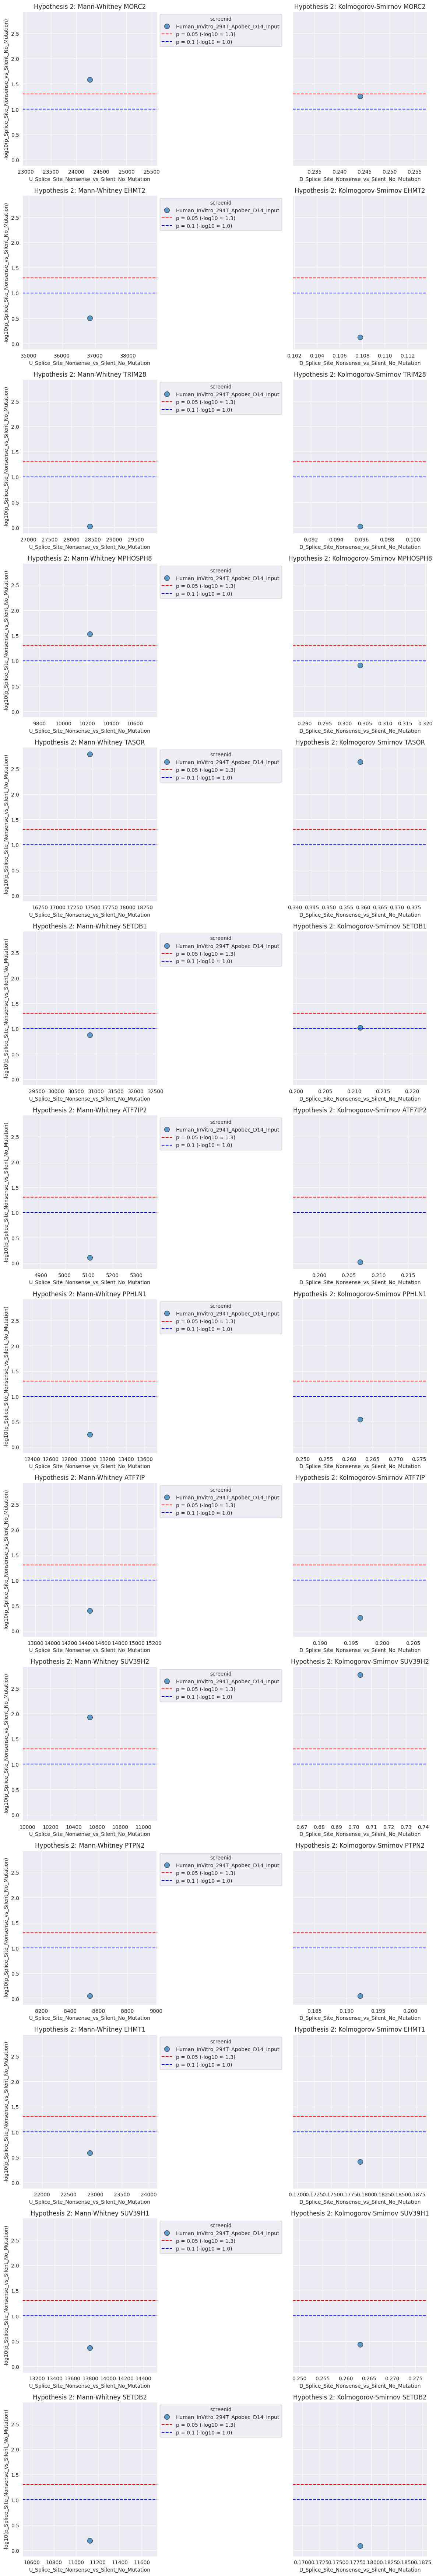

In [12]:
# @markdown Run hypothesis tests

from hypothesis_tests import hypothesis_tests
dfs = [pd.read_csv(f'{workdir}rawdata/{screen}', sep='\t') for screen in screens]

cases = 'Splice,Nonsense' # @param {type:"string"}
controls = 'Silent,No Mutation' # @param {type:"string"}
cases = cases.split(',')
controls = controls.split(',')
comp_name = 'Splice_Site_Nonsense_vs_Silent_No_Mutation' # @param {type:"string"}

hypothesis_tests(
    df_Inputs=dfs,
    workdir=workdir,
    input_gene=input_gene,
    input_screens=screens,
    cases=cases, controls=controls, comp_name=comp_name,
    mut_col=mut_col, val_col=val_col, gene_col=gene_col,
    )

In [13]:
# @markdown Randomize screen data

from beclust3d.randomize_be_results import randomize_be_results

screen_names = [screen.split('.')[0] for screen in screens]
df_missenses = [pd.read_csv(f'{workdir}SETDB1/screendata/{input_gene}_{screen_name}_Missense_edits_list.tsv', sep='\t') for screen_name in screen_names]
for df_missense, screen_name in zip(df_missenses, screen_names):
    randomize_be_results(
        df_missense=df_missense,
        workdir=workdir,
        input_gene=input_gene,
        input_screen=screen_name,
        )

In [ ]:
# @markdown Query Uniprot and AlphaFold and process files

from beclust3d.af_structural_features import af_structural_features

af_structural_features(
    workdir=workdir,
    input_gene=input_gene,
    input_uniprot=input_uniprot,
    structureid=structureid
    )

Human_InVitro_294T_Apobec_D14_Input.txt


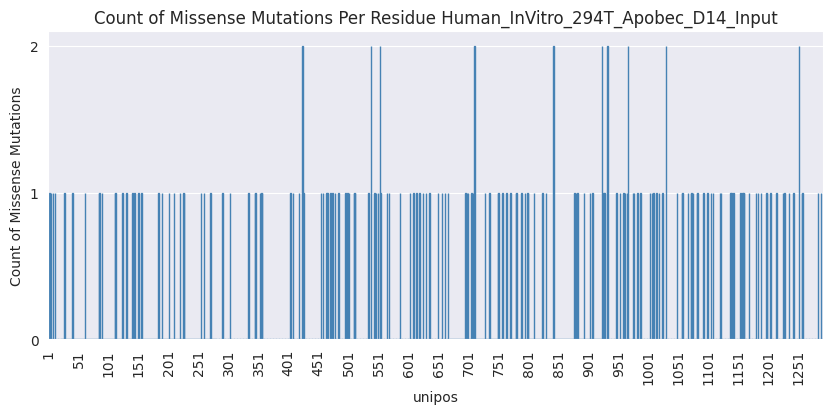

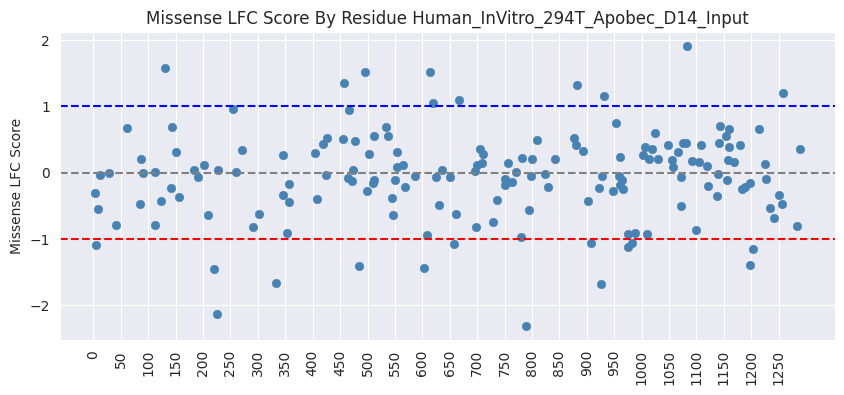

In [14]:
# @markdown Prioritize screen data by conservation \
# @markdown Optional: Query conservation MUSCLE

include_conservation = False #@param {type:"boolean"}

from beclust3d.prioritize_by_conservation import prioritize_by_conservation

df_struc = pd.read_csv(f"{workdir}{input_gene}/{structureid}_coord_struc_features.tsv", sep = "\t")
if include_conservation:
  from beclust3d.conservation import conservation

  # @markdown Optional Inputs
  input_mouse_gene = 'Setdb1' # @param {type:"string"}
  input_mouse_uniid = 'D3YYC3' # @param {type:"string"}
  email = 'xiaohu@g.harvard.edu' # @param {type:"string"}
  title = 'samplejob' # @param {type:"string"}

  df_alignconserv, df_residuemap = conservation(
      workdir=workdir,
      input_human_gene=input_gene, input_mouse_gene=input_mouse_gene,
      input_human_uniid=input_uniprot, input_mouse_uniid=input_mouse_uniid,
      email=email, title=title,
      )

  df_consrv = pd.read_csv(f"{workdir}{input_gene}/Human{input_gene}_MouseSetdb1_residuemap_conservation.tsv", sep = '\t')
else:
  df_consrv = None

for screen in screens:
    print(screen)
    out_df = prioritize_by_conservation(
            df_struc     =df_struc,
            df_consrv    =df_consrv,
            workdir      =workdir,
            input_gene   =input_gene,
            input_screen =screen,
            structureid  =structureid,
        )

In [15]:
# @markdown Randomize screen data prioritized by conservation

from beclust3d.randomize_by_conservation import randomize_by_conservation

for screen in screens:
    out_df = randomize_by_conservation(
        workdir      =workdir,
        input_gene   =input_gene,
        input_screen =screen,
        structureid  =structureid,
    )

# Calculate 3D LFC Scores and